# Waveform fitting

In [1]:
# Setup ipython environment
%load_ext autoreload
%autoreload 2
%matplotlib inline
from matplotlib.pyplot import *
from numpy import *
from positive import *
from nrutils import scsearch, gwylm
from glob import glob
import pwca
from pwca import determine_data_fitting_region,pwca_catalog,metadata_dict

(positive)>> Applying custom matplotlib settings.
(init)>> Warm greetings from Welsh Puck (aka pwca).
(pwca.core)>> Catalog of calibration runs stored to "pwca.pwca_catalog"
(pwca.core)>> Metadata dictionary for calibration runs stored to "pwca.metadata_dict"


## This notebook is for prototyping and scratch code only. Please see scripts with same issue number.

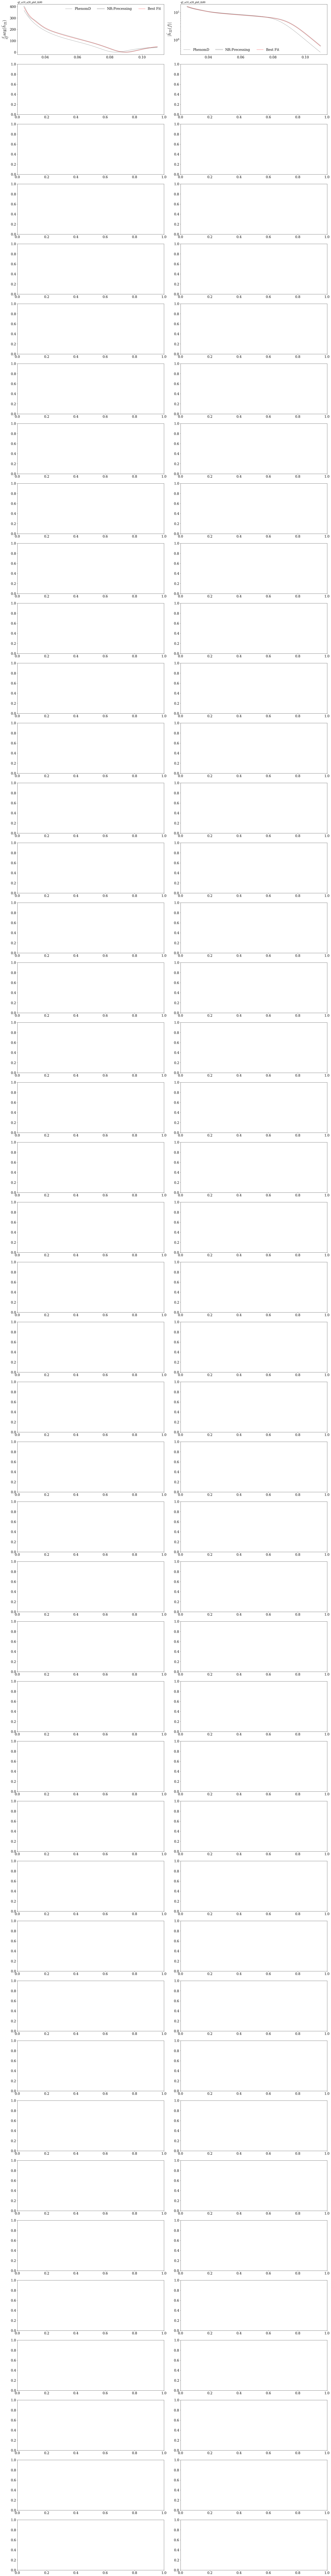

In [2]:

#
from numpy.linalg import norm
from scipy.optimize import curve_fit

#
datadir = '/Users/book/KOALA/puck/ll/data/version2/'
files = glob( datadir+'*.txt' )

#
fig,ax = subplots( len(files), 2, figsize=3*array([ 2.5*2/(0.618), 1.5*len(files) ]) )
ax = ax.flatten()

#
tight_layout(1,2,4)

#
foo = {}

#
p = 0
for f_ in files[::-1]:

    #
    simname = f_.split('/')[-1].split('.')[0]
    
    # Find index location of metadata for simname 
    k = list( metadata_dict['simname'] ).index(simname)
    
    # Load data for this case
    raw_data = loadtxt(f_).T
    data,_,fmin,fmax,fknot = determine_data_fitting_region(raw_data)
    
    # Collect params for this case 
    metadata = metadata_dict['array_data'][k,:]
    
    #
    f,amp_td,amp_fd,dphi_td,dphi_fd = data.T
    theta,m1,m2,eta,delta,chi_eff,chi_p,chi1,chi2,a1,a2 = metadata_dict['array_data'][k]
    
    # GENERATE TEMPLATE FUNCTIONS
    # ---
    template_amp, template_dphi, template_phi = pwca.template_amp_phase(m1, m2, chi1, chi2, chi_p)
    
    # PHASE DERIVATIVE
    # ---
    
    #
    phenomd_dphi = template_dphi(f)
    dphi_popt, dphi_pcov = curve_fit(template_dphi, f, dphi_td,p0=[0,0,0])
    best_fit_dphi = template_dphi(f,*dphi_popt)
    
    # AMPLITUDE
    # ---
    
    #
    amp_scale = f ** (7.0/6)
    inv_amp_scale = f ** (-7.0/6)
    
    #
    log_scaled_template_amp = lambda X,MU0,MU1,MU2,MU3,MU4: log(  template_amp(X,MU0,MU1,MU2,MU3,MU4)*amp_scale  )
    phenomd_amp = template_amp(f)
    
    #
    scaled_amp_fd = amp_fd * amp_scale
    log_scaled_amp_fd = log(scaled_amp_fd)
    log_scaled_amp_popt, log_amp_pcov = curve_fit(log_scaled_template_amp, f, log_scaled_amp_fd,p0=[0,0,0,0,0])
    best_fit_amp = exp(log_scaled_template_amp(f,*log_scaled_amp_popt)) * inv_amp_scale
    
    # PLOTTING
    # ---
    
    
    #figure( figsize=1.5*figaspect(0.5*0.618/2) )
    
    #subplot(1,2,1)
    sca(ax[p]); p+=1
    plot( f, phenomd_dphi, label='PhenomD', ls='--',alpha=0.9,color='k' )
    plot( f, dphi_td, label='NR:Precessing', color='k', alpha=0.15, lw=6 )
    plot( f, best_fit_dphi, label='Best Fit', color='r', ls='-' )
    title(simname,size=12,loc='left')
    legend(ncol=3,loc=1)
    ylabel(r'$\frac{d}{df}\arg(\tilde{h}_{22})$')
    if p==(len(files)-2):  xlabel('$fM$')
    #
    title(f_.split('/')[-1].split('.')[0],loc='left',size=12)
    
    #subplot(1,2,2)
    sca(ax[p]); p+=1
    plot( f, phenomd_amp, label='PhenomD', ls='--',alpha=0.9,color='k' )
    plot( f, amp_fd, label='NR:Precessing', color='k', alpha=0.15, lw=6 )
    plot( f, best_fit_amp, label='Best Fit', color='r', ls='-' )
    title(simname,size=12,loc='left')
    yscale('log')
    legend(ncol=3,loc=3)
    ylabel(r'$|\tilde{h}_{22}(f)|$')
    #
    title(f_.split('/')[-1].split('.')[0],loc='left',size=12)
    
    #
    break
        
    

In [ ]:


#
for f in files:
    
    #
    alert('Loading %s'%red(f))
    raw_data = loadtxt(f).T
    
    #
    data,_,fmin,fmax = determine_data_fitting_region(raw_data)
    
    #
    md = collect_file_metadata( f )
    
    #
    f,amp_td,amp_fd,dphi_td,dphi_fd = d.T

In [ ]:

figure()

for d in data:
    
    f,amp_td,amp_fd,dphi_td,dphi_fd = d.T
    
    plot( f, dphi_td-min(dphi_td) )